In [2]:
import sqlite3
import numpy as np
# %load_ext cudf.pandas
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

import sweetviz as sv
# import cudf




# # We want to list the columns in 3 categories.
# def columns_categories(data_set):
#     object_columns = []
#     float_columns = []
#     int_columns = []
#     other_columns = []
#     n,m,s=0,0,0
#     for i in data_set.columns.values:
#         if data_set[i].dtypes=='object':
#             object_columns.append(i)
#             n+=1
#         if data_set[i].dtypes=='int':
#             int_columns.append(i)
#             m+=1
#         if data_set[i].dtypes=='float':
#             float_columns.append(i)
#             s+=1
#     print('object(',n,'):\n',object_columns)
#     print('int(',m,'):\n',int_columns)
#     print('float(',s,'):\n',float_columns)



In [3]:
# SQLite データベースに接続
connect = sqlite3.connect("telecom.sqlite3")

# テーブル一覧を表示
cursor = connect.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

# テーブル名を表示
for table in tables:
    print(table[0])

# 接続を閉じる
connect.close()


connect = sqlite3.connect("telecom.sqlite3")

record = pd.read_sql("select * from Record", con=connect)
client = pd.read_sql("select * from Client", con=connect)

Record
Client


In [4]:
uni_df = pd.merge(record, client, on="Customer_ID", how="inner")
uni_df.dtypes
uni_df

,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,ovrrev_Mean,vceovr_Mean,datovr_Mean,roam_Mean,change_mou,...,dwllsize,forgntvl,ethnic,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd,eqpdays
0,23.9975,219.25,22.500,0.2475,0.00,0.0,0.0,0.0,0.0,-157.25,...,A,0.0,N,U,U,U,U,U,Y,361.0
1,57.4925,482.75,37.425,0.2475,22.75,9.1,9.1,0.0,0.0,532.25,...,A,0.0,Z,U,U,U,U,U,Y,240.0
2,16.9900,10.25,16.990,0.0000,0.00,0.0,0.0,0.0,0.0,-4.25,...,A,0.0,N,U,Y,U,U,U,Y,1504.0
3,38.0000,7.50,38.000,0.0000,0.00,0.0,0.0,0.0,0.0,-1.50,...,D,0.0,U,Y,U,U,U,U,Y,1812.0
4,55.2300,570.50,71.980,0.0000,0.00,0.0,0.0,0.0,0.0,38.50,...,O,0.0,I,U,U,U,U,U,Y,434.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,A,0.0,S,U,U,U,Y,U,Y,773.0
99996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,A,0.0,N,U,U,Y,Y,Y,Y,835.0
99997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,0.0,U,Y,Y,U,U,U,N,433.0
99998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,0.0,S,U,U,U,U,U,N,75.0


In [5]:


uni_df = uni_df.dropna(subset=["change_mou"])

uni_df[uni_df["change_mou"].isna() == True]
analy_df = uni_df
analy_df = analy_df[0 <= analy_df["rev_Mean"]]

# obj = analy_df.select_dtypes(include=['object']).columns
# print(obj)

# sns.countplot(data=analy_df, x="churn")
# plt.show()

In [6]:
columns_to_encode = ['new_cell', 'crclscod', 'asl_flag', 'prizm_social_one', 'area', \
       'dualband', 'refurb_new', 'hnd_price', 'hnd_webcap', 'ownrent', \
       'dwlltype', 'marital', 'infobase', 'numbcars', 'HHstatin', 'dwllsize', \
       'ethnic', 'kid0_2', 'kid3_5', 'kid6_10', 'kid11_15', 'kid16_17', \
       'creditcd']


label_encoder = LabelEncoder()
# 各カラムに対してラベルエンコーディングを実施
for column in columns_to_encode:
    # 欠損値を考慮してfit_transform
    analy_df[column] = label_encoder.fit_transform(analy_df[column].astype(str))



analy_df["MOUMEAN_PER_CHMOU"] = (analy_df["change_mou"]) / analy_df["mou_Mean"]
analy_df["revMean_PER_mouMean"] = ((analy_df["rev_Mean"]) / (analy_df["mou_Mean"]))


from sklearn.model_selection import train_test_split
import lightgbm as lgb


X = analy_df.drop(['churn', 'Customer_ID', "drop_vce_Mean"], \
                #    "blck_vce_Mean", "blck_dat_Mean", "unan_vce_Mean", "unan_dat_Mean", "plcd_vce_Mean", "plcd_dat_Mean", "recv_vce_Mean", \
                #     "recv_sms_Mean", "comp_vce_Mean", "comp_dat_Mean", "custcare_Mean"], \
                  axis=1)
y = analy_df['churn'] # 目的変数
# トレーニングデータ,テストデータの分割

# analy_df["avg6mou"].fillna(analy_df["avg6mou"].mean(), inplace=True)

X_train, X_valid, y_train, y_valid = train_test_split(X, y,test_size=0.2, random_state=0)

/var/folders/49/ktrg8hdn3tq6yglt3y32ldzr0000gn/T/ipykernel_60795/2749792157.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analy_df[column] = label_encoder.fit_transform(analy_df[column].astype(str))
/var/folders/49/ktrg8hdn3tq6yglt3y32ldzr0000gn/T/ipykernel_60795/2749792157.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analy_df[column] = label_encoder.fit_transform(analy_df[column].astype(str))
/var/folders/49/ktrg8hdn3tq6yglt3y32ldzr0000gn/T/ipykernel_60795/2749792157.py:12: SettingWithCopyWa

In [7]:


# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)





from lightgbm import LGBMClassifier

lgb_model = LGBMClassifier(random_state=0, learning_rate=0.02, num_leaves=26, max_depth=7, reg_alpha=0.1, reg_lambda=0.1)
lgb_model.fit(X_train, y_train)

lgb_train_pred = lgb_model.predict_proba(X_train)[:, 1]
lgb_valid_pred = lgb_model.predict_proba(X_valid)[:, 1]
print(f"Train Score: {roc_auc_score(y_train, lgb_train_pred)}")
print(f"Valid Score: {roc_auc_score(y_valid, lgb_valid_pred)}")

[LightGBM] [Info] Number of positive: 39148, number of negative: 40137
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062645 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15083
[LightGBM] [Info] Number of data points in the train set: 79285, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493763 -> initscore=-0.024949
[LightGBM] [Info] Start training from score -0.024949
Train Score: 0.6891107094046358
Valid Score: 0.6726295141568868


In [8]:
# 学習に使用するデータを設定
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

# パラメータ
params = {
    'objective': 'binary',
    'metric': 'auc',
    'verbosity': -1,
}


# モデルの学習
model = lgb.train(params,
                  train_set=lgb_train, # トレーニングデータの指定
                  valid_sets=lgb_eval, # 検証データの指定
                  )

# テストデータの予測
y_pred = model.predict(X_valid)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

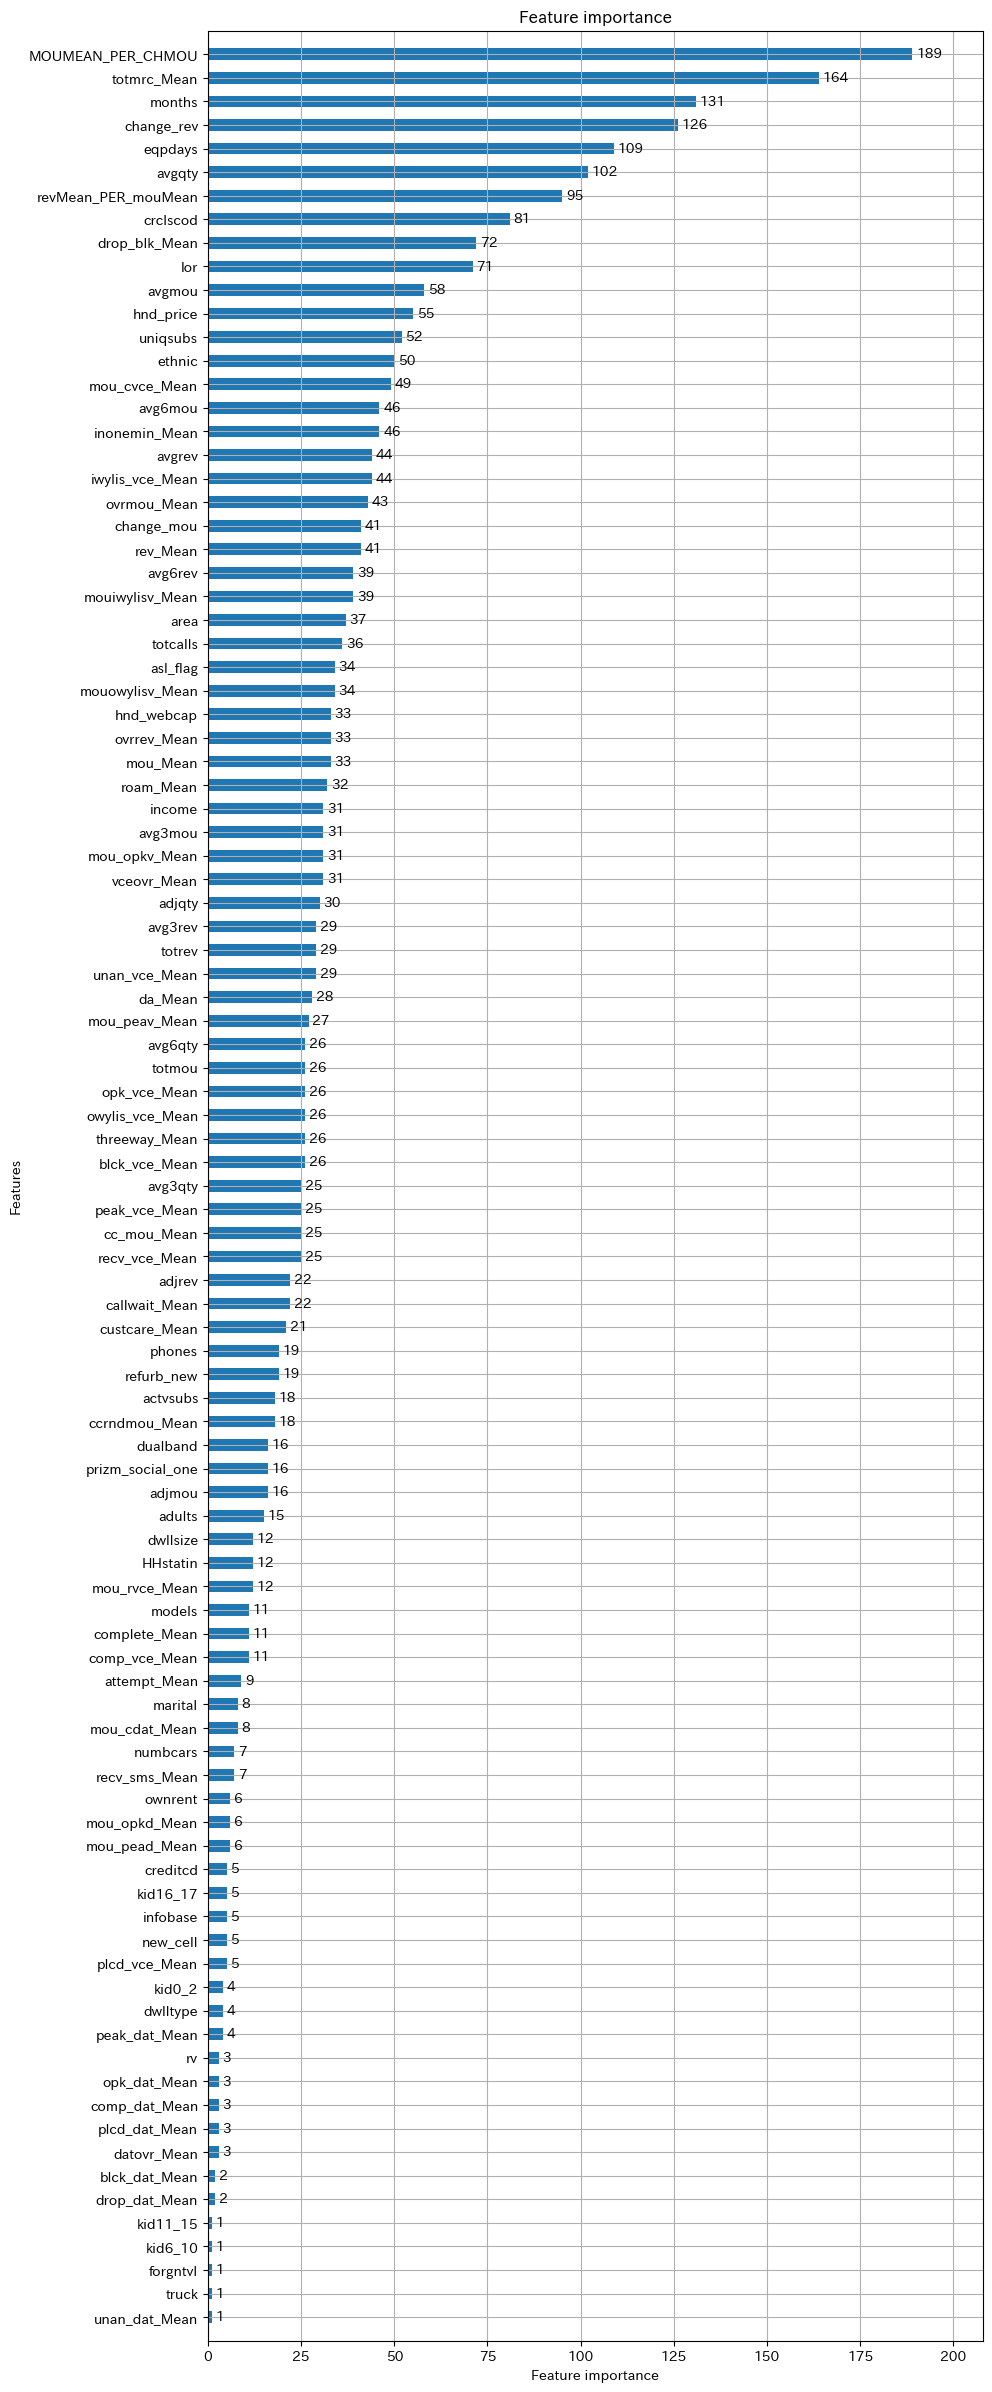

In [9]:
lgb.plot_importance(model, height=0.5, figsize=(10,30))

- change_mou: 月間利用時間の前三か月平均との比較の変化率 
- mou_Mean: 月間平均利用時間
- totmrc_Mean: 月間平均総月額従量課金
- change_rev: 月間収益の前三か月平均との比較の変化率
- months: サービス利用期間の総月数
- eqpdays: 現在の機器の日数
- avgqty: 顧客の生涯平均月間通話回数
- avgmou: 顧客の生涯平均月間利用時間
- crclscod: 信用クラスコード
- mou_cvce_Mean: 完了した音声通話の丸められていない利用時間の月間平均 
- lor: 居住期間
- drop_vce_Mean: 失敗した音声通話の月間平均数 
- avg6mou: 直近6か月の平均月間利用時間
- avgrev: 顧客の生涯平均月間収益
- hnd_price: 現在の携帯電話の価格
- drop_blk_Mean: ドロップまたはブロックされた通話の月間平均数
- rev_Mean: 月間平均収益（課金額）


- ethnic: 民族の統合コード

- avg3mou: 直近3か月の平均月間利用時間

- mou_peav_Mean: ピーク時の音声通話の丸められていない利用時間の月間平均 


- avg6rev: 直近6か月の平均月間収益

In [10]:
no_churn = (record["churn"] == 0).sum()
churn = (record["churn"] == 1).sum()

res = churn / (no_churn + churn)
res

print("no_churn", no_churn)
print("churn", churn)
print("sum", no_churn + churn)
print("%", res)

no_churn 50438
churn 49562
sum 100000
% 0.49562


In [11]:
churn = analy_df[analy_df["churn"] == 1]
no_churn = analy_df[analy_df["churn"] == 0]

In [12]:
analy_df[0 < analy_df["kid6_10"]]["kid6_10"].shape[0]

97390

In [13]:
m_300 = analy_df[analy_df["avg6mou"] < 300]
m_ov300 = analy_df[300 <= analy_df["avg6mou"]]

In [14]:
m_ov300["totmrc_Mean"].mean()

54.636854842135065

In [15]:
ch1 = analy_df[(analy_df["churn"] == 1) & ((300 <= analy_df["eqpdays"] ) & (analy_df["eqpdays"] <= 420))]

In [16]:
ch1_price = ch1["rev_Mean"].mean()
ch1_price

54.40333563068174

In [17]:
analy_df[analy_df["avgqty"] <= 1]["rev_Mean"].sum()

5332.055

In [18]:
analy_df[((analy_df["mou_Mean"] < 1)) & (analy_df["churn"] == 1) & (29 <= analy_df["rev_Mean"])]["rev_Mean"].describe()


count    509.000000
mean      43.978070
std       18.061612
min       29.005000
25%       30.260000
50%       35.990000
75%       50.000000
max      163.230000
Name: rev_Mean, dtype: float64

In [23]:
analy_df[((analy_df["avg6mou"] < 300)) & (analy_df["churn"] == 1) & (analy_df["rev_Mean"] < 29)]["rev_Mean"].describe()

count    4838.000000
mean       17.317638
std         6.654564
min         1.372500
25%        10.593750
50%        17.185000
75%        22.816250
max        28.995000
Name: rev_Mean, dtype: float64

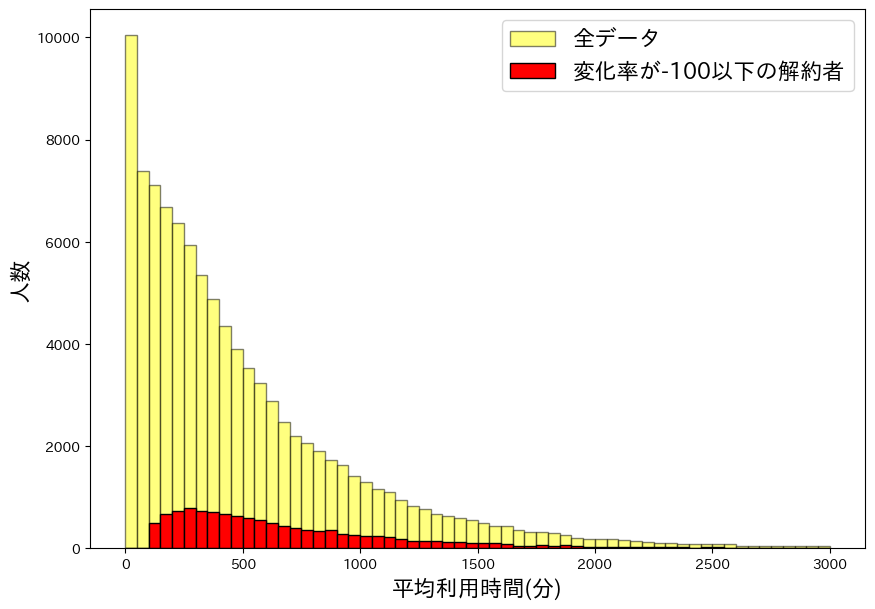

708.7778281537632
514.3815198892938


In [24]:
test = analy_df[((analy_df["change_mou"] <= -100) & (analy_df["churn"] == 1)) ]
test2 = analy_df#[((-100 <= analy_df["change_mou"]) & (analy_df["churn"] == 1))]


plt.figure(figsize=(10, 7))
plt.xlabel("平均利用時間(分)", fontsize=16)
plt.ylabel("人数", fontsize=16)


plt.hist(x=test2["mou_Mean"], \
		 bins=60, range=(0, 3000), edgecolor='black', color="yellow", alpha=0.5, label="全データ")

plt.hist(x=test["mou_Mean"], \
		 bins=60, range=(0, 3000), edgecolor='black', color="red", label='変化率が-100以下の解約者')

# 目盛りのフォントサイズを変更
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.legend(fontsize='16')

plt.show()
print(test["mou_Mean"].mean())
print(test2["mou_Mean"].mean())

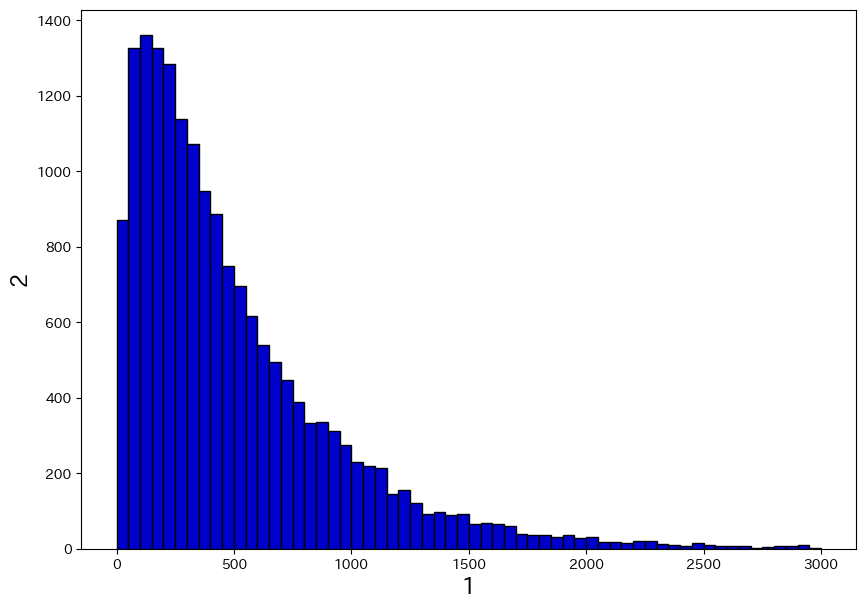

In [26]:
test = analy_df[((10 < analy_df["change_mou"])) & (analy_df["churn"] == 1)]


plt.figure(figsize=(10, 7))
plt.xlabel("1", fontsize=16)
plt.ylabel("2", fontsize=16)

plt.hist(x=test["avg6mou"], \
		 bins=60, range=(0, 3000), edgecolor='black', color="mediumblue", label='非解約')

# 目盛りのフォントサイズを変更
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

In [27]:
analy_df[((analy_df["change_mou"] <= -100) & (analy_df["churn"] == 1)) ]["ovrmou_Mean"].describe()

count    12131.000000
mean        68.271144
std        121.069351
min          0.000000
25%          0.000000
50%         25.750000
75%         85.000000
max       2239.250000
Name: ovrmou_Mean, dtype: float64

In [28]:
analy_df["totmrc_Mean"].describe()

count    99107.000000
mean        46.288437
std         23.591306
min        -26.915000
25%         30.000000
50%         44.990000
75%         59.990000
max        409.990000
Name: totmrc_Mean, dtype: float64

In [29]:
ch_mou6 = analy_df[((analy_df["change_mou"] <= -100) & (analy_df["churn"] == 1)) ]
ch_mou6[((ch_mou6["avg6mou"] <= 1000) & (50 <= ch_mou6["totmrc_Mean"]))].shape[0]

3022

In [30]:
analy_df.loc[1234, ["rev_Mean", "totmrc_Mean", "ovrrev_Mean", "churn"]]

rev_Mean       31.4500
totmrc_Mean    29.2475
ovrrev_Mean     0.0900
churn           1.0000
Name: 1234, dtype: float64

In [31]:
analy_df[((analy_df["change_mou"] <= -100) & (analy_df["churn"] == 1) & ((29 <= analy_df["totmrc_Mean"]) & (analy_df["totmrc_Mean"] <= 39)) ) ] \
		["totmrc_Mean"].shape[0]

1884

In [32]:
analy_df[( (10 < analy_df["change_mou"]) & (analy_df["churn"] == 1)) ]["totmrc_Mean"].describe()

count    18039.000000
mean        46.620284
std         22.280261
min         -5.725000
25%         30.000000
50%         44.990000
75%         59.990000
max        319.990000
Name: totmrc_Mean, dtype: float64

In [33]:
analy_df["totmrc_Mean"].describe()

count    99107.000000
mean        46.288437
std         23.591306
min        -26.915000
25%         30.000000
50%         44.990000
75%         59.990000
max        409.990000
Name: totmrc_Mean, dtype: float64

In [34]:
analy_df[(300 <= analy_df["eqpdays"]) & (analy_df["eqpdays"] <= 500)]["churn"].mean()

0.5669166873295314

max change_mou    31219.25
dtype: float64
min change_mou   -3875.0
dtype: float64


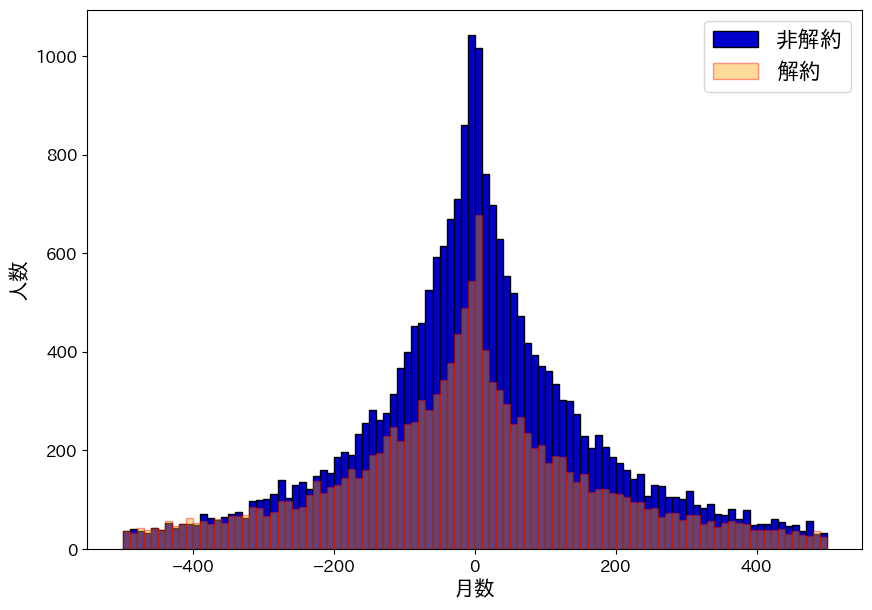

In [35]:
test = analy_df[(analy_df["eqpdays"] <= 300)]

# グラフの大きさ指定
feau = ["change_mou"]
plt.figure(figsize = (10, 7))

print("max", analy_df[feau].max())
print("min", analy_df[feau].min())

# x軸のラベルを指定
# plt.title()
plt.xlabel('月数', fontsize=15)
plt.ylabel("人数", fontsize=15)

# 対数スケールに設定
# plt.xscale('log')

# ヒストグラムの描写
# plt.hist(x=analy_df['avg6mou'], bins=100, range=(0, 3000), edgecolor='black')
plt.hist(x=test[test["churn"] == 0][feau], bins=100, range=(-500, 500), edgecolor='black', color="mediumblue", label='非解約')
plt.hist(x=test[test["churn"] == 1][feau], bins=100, range=(-500, 500), color="orange", edgecolor='red', alpha=0.4, label='解約')
# Seabornで描写する場合
#sns.histplot(data=df, x='sepal_length', bins=25, binrange=(4.5, 7.5))

# 目盛りのフォントサイズを変更
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.legend(fontsize='16')

plt.show()

In [36]:
(analy_df[0 < analy_df["ovrrev_Mean"]]["ovrrev_Mean"] / analy_df[0 < analy_df["ovrmou_Mean"]]["ovrmou_Mean"]).describe()

count    56806.000000
mean         0.352256
std          0.192935
min          0.014553
25%          0.300000
50%          0.350000
75%          0.390000
max         39.890000
dtype: float64

In [37]:
(analy_df[0 < analy_df["totmrc_Mean"]]["totmrc_Mean"] / analy_df[0 < analy_df["mou_Mean"]]["mou_Mean"]).describe()

count    97450.000000
mean         0.569019
std          5.271509
min          0.001200
25%          0.067587
50%          0.115077
75%          0.230017
max        439.960000
dtype: float64

In [38]:
uni_df["rev_Mean"].isna().sum()

0

In [156]:
# SQLite データベースに接続
connect = sqlite3.connect("telecom.sqlite3")

# テーブル一覧を表示
cursor = connect.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

# テーブル名を表示
for table in tables:
    print(table[0])

# 接続を閉じる
connect.close()


connect = sqlite3.connect("telecom.sqlite3")

record = pd.read_sql("select * from Record", con=connect)
client = pd.read_sql("select * from Client", con=connect)

uni_df = pd.merge(record, client, on="Customer_ID", how="inner")

uni_df = uni_df.dropna(subset=["change_mou"])

uni_df[uni_df["change_mou"].isna() == True]
analy_df = uni_df

analy_df = analy_df[0 < analy_df["mou_Mean"]]

Record
Client


In [157]:
columns_to_encode = ['new_cell', 'crclscod', 'asl_flag', 'prizm_social_one', 'area', \
       'dualband', 'refurb_new', 'hnd_price', 'hnd_webcap', 'ownrent', \
       'dwlltype', 'marital', 'infobase', 'numbcars', 'HHstatin', 'dwllsize', \
       'ethnic', 'kid0_2', 'kid3_5', 'kid6_10', 'kid11_15', 'kid16_17', \
       'creditcd']


label_encoder = LabelEncoder()
# 各カラムに対してラベルエンコーディングを実施
for column in columns_to_encode:
    # 欠損値を考慮してfit_transform
    analy_df[column] = label_encoder.fit_transform(analy_df[column].astype(str))



analy_df["MOUMEAN_PER_CHMOU"] = (analy_df["change_mou"]) / analy_df["mou_Mean"]
analy_df["revMean_PER_mouMean"] = ((analy_df["rev_Mean"]) / (analy_df["mou_Mean"]))


from sklearn.model_selection import train_test_split
import lightgbm as lgb


X = analy_df.drop(['churn', 'Customer_ID', "drop_vce_Mean"], \
                #    "blck_vce_Mean", "blck_dat_Mean", "unan_vce_Mean", "unan_dat_Mean", "plcd_vce_Mean", "plcd_dat_Mean", "recv_vce_Mean", \
                #     "recv_sms_Mean", "comp_vce_Mean", "comp_dat_Mean", "custcare_Mean"], \
                  axis=1)
y = analy_df['churn'] # 目的変数

/var/folders/49/ktrg8hdn3tq6yglt3y32ldzr0000gn/T/ipykernel_60795/3740071960.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analy_df[column] = label_encoder.fit_transform(analy_df[column].astype(str))
/var/folders/49/ktrg8hdn3tq6yglt3y32ldzr0000gn/T/ipykernel_60795/3740071960.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analy_df[column] = label_encoder.fit_transform(analy_df[column].astype(str))
/var/folders/49/ktrg8hdn3tq6yglt3y32ldzr0000gn/T/ipykernel_60795/3740071960.py:12: SettingWithCopyWa

max revMean_PER_mouMean   440.21
dtype: float64
min revMean_PER_mouMean   0.00
dtype: float64


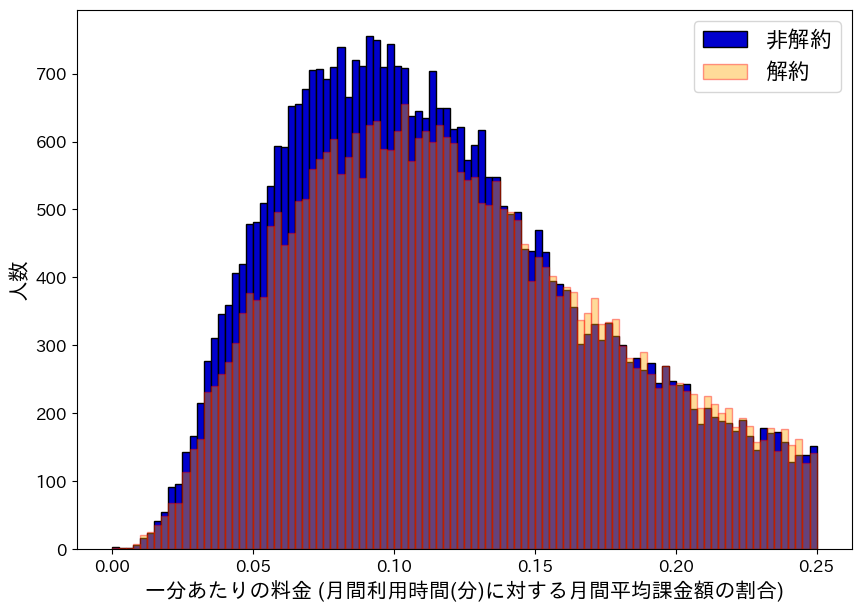

In [191]:
feau = ["revMean_PER_mouMean"]
plt.figure(figsize = (10, 7))

print("max", analy_df[feau].max())
print("min", analy_df[feau].min())

# x軸のラベルを指定
# plt.title()
plt.xlabel('一分あたりの料金 (月間利用時間(分)に対する月間平均課金額の割合)', fontsize=15)
plt.ylabel("人数", fontsize=15)

# 対数スケールに設定
# plt.xscale('log')

# ヒストグラムの描写
# plt.hist(x=analy_df['avg6mou'], bins=100, range=(0, 3000), edgecolor='black')
plt.hist(x=analy_df[analy_df["churn"] == 0][feau], bins=100, range=(0, .25), edgecolor='black', color="mediumblue", label='非解約')
plt.hist(x=analy_df[analy_df["churn"] == 1][feau], bins=100, range=(0, .25), color="orange", edgecolor='red', alpha=0.4, label='解約')
# Seabornで描写する場合
#sns.histplot(data=df, x='sepal_length', bins=25, binrange=(4.5, 7.5))

# 目盛りのフォントサイズを変更
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.legend(fontsize='16')

plt.show()

In [193]:
analy_df["revMean_PER_mouMean"].describe()

count   97595.00
mean        0.57
std         5.01
min         0.00
25%         0.09
50%         0.14
75%         0.25
max       440.21
Name: revMean_PER_mouMean, dtype: float64

In [232]:
# lgb_model = LGBMClassifier(random_state=0, learning_rate=0.02, num_leaves=26, max_depth=7, reg_alpha=0.1, reg_lambda=0.1)
# lgb_model.fit(X_train, y_train)

# lgb_train_pred = lgb_model.predict_proba(X_train)[:, 1]
# lgb_valid_pred = lgb_model.predict_proba(X_valid)[:, 1]
# print(f"Train Score: {roc_auc_score(y_train, lgb_train_pred)}")
# print(f"Valid Score: {roc_auc_score(y_valid, lgb_valid_pred)}")

analy_df[(0.09 < analy_df["revMean_PER_mouMean"]) & (analy_df["revMean_PER_mouMean"] <= 0.1)]["churn"].mean()

0.45078776645041707

In [233]:



lgb_model = LGBMClassifier(random_state=0, learning_rate=0.02, num_leaves=26, max_depth=7, reg_alpha=0.1, reg_lambda=0.1)
lgb_model.fit(X, y)

analy_df_pred = lgb_model.predict_proba(X)[:, 1]


lgb_train_pred_binary = (analy_df_pred >= 0.5).astype(int)

churned_data_train = analy_df[lgb_train_pred_binary == 1]

churned_data_train["churn"].mean()

[LightGBM] [Info] Number of positive: 47685, number of negative: 49910
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15300
[LightGBM] [Info] Number of data points in the train set: 97595, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.488601 -> initscore=-0.045605
[LightGBM] [Info] Start training from score -0.045605


0.6217920236961811

In [234]:
pd.options.display.float_format = '{:.2f}'.format

grpd_df = churned_data_train[0.1 < churned_data_train["revMean_PER_mouMean"]]

print("rate:", grpd_df["churn"].mean())
print("data amou:", grpd_df.shape[0])

ch0_df = grpd_df[grpd_df["churn"] == 0]
ch1_df = grpd_df[grpd_df["churn"] == 1]

print("ch 0 rev:", ch0_df["mou_Mean"].sum() * 0.1)
print("ch 1 rev:", ch1_df["mou_Mean"].sum() * 0.1)



rate: 0.6297268907563025
data amou: 36176
ch 0 rev: 425998.59166668705
ch 1 rev: 698876.8041667378


In [142]:
# pd.options.display.float_format = '{:.2f}'.format

# # xを0.1から10まで0.2ずつ大きくしたリスト
# x_values = np.arange(0.1, 4, 0.02)

# # 各xに対する差分の絶対値を保存するリスト
# diff_values = []

# for x in x_values:
#     grpd_df = churned_data_train[x < churned_data_train["revMean_PER_mouMean"]]
    
#     # グループ内でchurnが0と1のデータに分割
#     ch0_df = grpd_df[grpd_df["churn"] == 0]
#     ch1_df = grpd_df[grpd_df["churn"] == 1]
    
#     # 差分の絶対値を計算してリストに追加
#     diff_values.append((ch1_df["mou_Mean"].sum() * 0.1) / (ch1_df["mou_Mean"].sum() * 0.1 + ch0_df["mou_Mean"].sum() * 0.1))

# # グラフの描画
# plt.figure(figsize = (10, 10))
# plt.plot(x_values, diff_values)
# plt.xlabel('Threshold (revMean_PER_mouMean)')
# plt.ylabel('Absolute Difference')
# plt.title('Absolute Difference between ch0 and ch1 revenue')
# plt.show()

In [153]:
# # グラフ用のデータを格納するリスト
# x_values = []
# res_values = []


# # all_ch0_rev = (df3[df3["churn"] == 0]["rev_Mean"].sum())

# # xが0.05増加するごとに計算
# for ratio in np.arange(0, 1.1, 0.1):

#     grpd_df = churned_data_train[0.1 < churned_data_train["revMean_PER_mouMean"]]


#     ch0_df = grpd_df[grpd_df["churn"] == 0]
#     ch1_df = grpd_df[grpd_df["churn"] == 1]

#     sampled_ch0_df = ch0_df.sample(frac=ratio, random_state=42)  # random_stateは再現性のためのシード

#     df3 = pd.merge(analy_df, sampled_ch0_df, how='left', indicator=True).query('_merge == "left_only"').drop('_merge', axis=1)


#     # res = ((df3[df3["churn"] == 0]["rev_Mean"].sum()) + \
#     #        (ch1_df["mou_Mean"].sum()) * 0.1 + (ch0_df["mou_Mean"].sum() * 0.1 - ch0_df["rev_Mean"].sum())) \
#     #        - 2976633.2633336103

#     res = ((df3[df3["churn"] == 0]["rev_Mean"].sum()) + \
#            (ch1_df["mou_Mean"].sum()) * 0.1 + (sampled_ch0_df["mou_Mean"].sum() * 0.1 - sampled_ch0_df["rev_Mean"].sum())) \
#            - 2976633.2633336103

#     # グラフ用のデータを追加
#     x_values.append(sampled_ch0_df.shape[0] / ch1_df.shape[0])
#     res_values.append(res)

# # グラフの作成
# plt.figure(figsize=(12, 10))
# plt.plot(x_values, res_values, linestyle='-')
# plt.xlabel('解約する人に対する解約と判定された非解約者の割合', fontsize=16)
# plt.ylabel('事業実施後の収益 ー 事業実施前の月間収益', fontsize=16)
# # plt.title('res vs. x')

# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)

# plt.grid(True)
# plt.show()

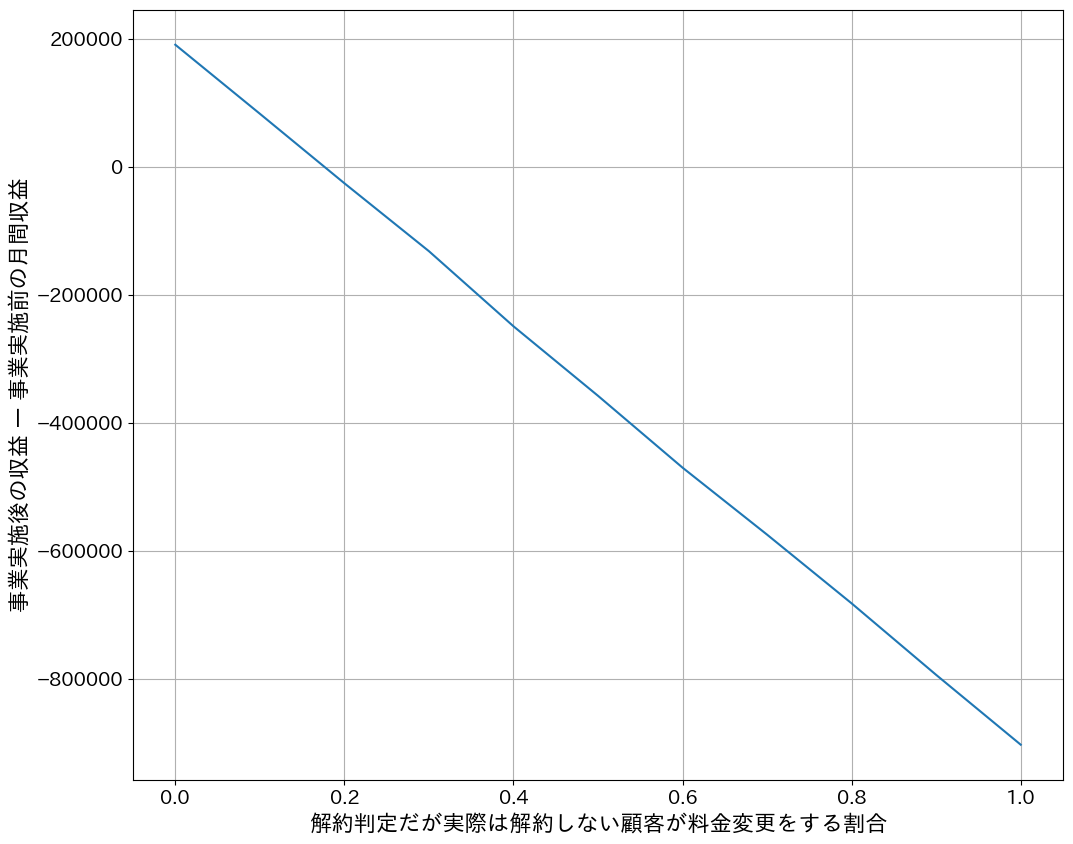

In [244]:
# グラフ用のデータを格納するリスト
x_values = []
res_values = []


# all_ch0_rev = (df3[df3["churn"] == 0]["rev_Mean"].sum())

# xが0.05増加するごとに計算
for ratio in np.arange(0, 1.1, 0.1):

    grpd_df = churned_data_train[0.1 < churned_data_train["revMean_PER_mouMean"]]


    ch0_df = grpd_df[grpd_df["churn"] == 0]
    ch1_df = grpd_df[grpd_df["churn"] == 1]

    sampled_ch0_df = ch0_df.sample(frac=ratio, random_state=42)  # random_stateは再現性のためのシード

    df3 = pd.merge(analy_df, sampled_ch0_df, how='left', indicator=True).query('_merge == "left_only"').drop('_merge', axis=1)



    res = ((df3[df3["churn"] == 0]["rev_Mean"].sum()) + \
           (ch1_df["mou_Mean"].sum() * 0.1 * ((1 / 0.6297) * 0.1790)) + (sampled_ch0_df["mou_Mean"].sum() * 0.1 - sampled_ch0_df["rev_Mean"].sum())) \
           - (2976633.2633336103)

    # グラフ用のデータを追加
    # x_values.append(sampled_ch0_df.shape[0] / ch1_df.shape[0])
    x_values.append(ratio)

    res_values.append(res)

# グラフの作成
plt.figure(figsize=(12, 10))
plt.plot(x_values, res_values, linestyle='-')
plt.xlabel('解約判定だが実際は解約しない顧客が料金変更をする割合', fontsize=16)
plt.ylabel('事業実施後の収益 ー 事業実施前の月間収益', fontsize=16)
# plt.title('res vs. x')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.grid(True)
plt.show()

In [181]:
grpd_df = churned_data_train[0.1 < churned_data_train["revMean_PER_mouMean"]]


ch0_df = grpd_df[grpd_df["churn"] == 0]
ch1_df = grpd_df[grpd_df["churn"] == 1]

sampled_ch0_df = ch0_df.sample(frac=0, random_state=42)  # random_stateは再現性のためのシード

df3 = pd.merge(analy_df, sampled_ch0_df, how='left', indicator=True).query('_merge == "left_only"').drop('_merge', axis=1)


# res = ((df3[df3["churn"] == 0]["rev_Mean"].sum()) + \
#        (ch1_df["mou_Mean"].sum()) * 0.1 + (ch0_df["mou_Mean"].sum() * 0.1 - ch0_df["rev_Mean"].sum())) \
#        - 2976633.2633336103

res = ((df3[df3["churn"] == 0]["rev_Mean"].sum()) + \
		(ch1_df["mou_Mean"].sum() * 0.1 * ((1 / 0.6297) * 0.1790)) + (sampled_ch0_df["mou_Mean"].sum() * 0.1 - sampled_ch0_df["rev_Mean"].sum())) \
		- (2976633.2633336103)

res

191123.85988740344

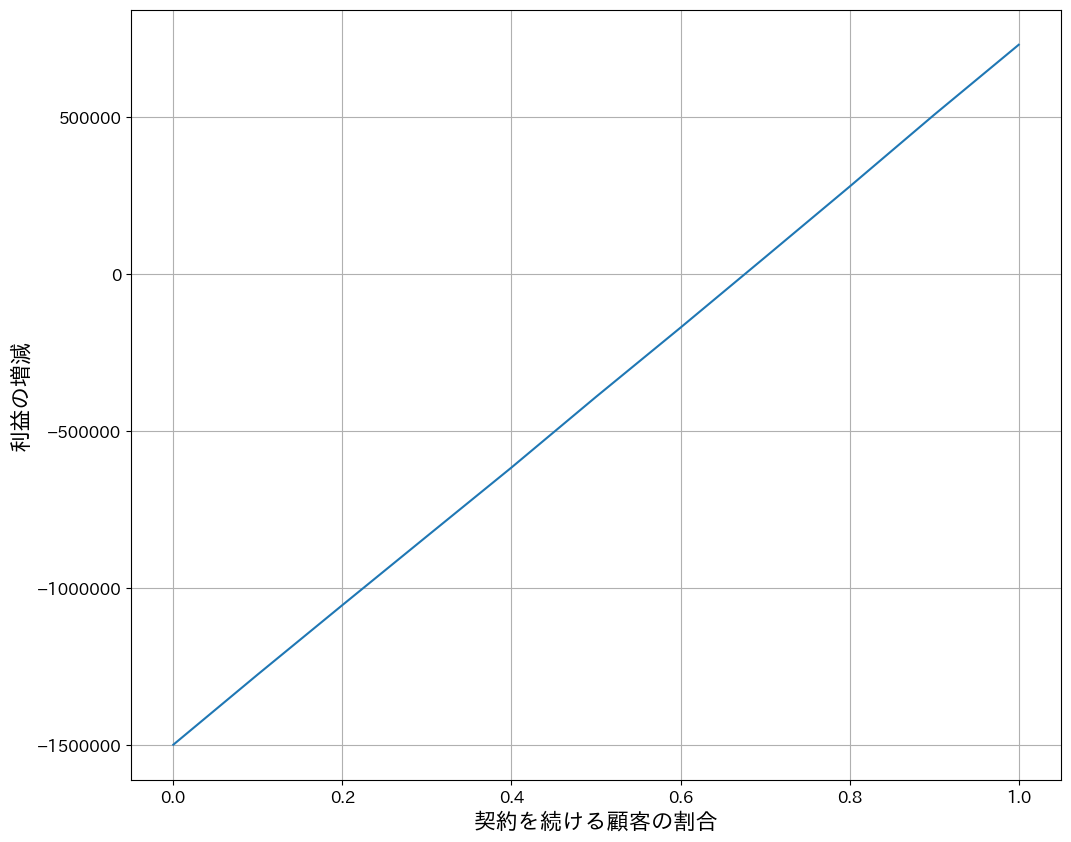

In [182]:
pd.options.display.float_format = '{:.2f}'.format


# グラフ用のデータを格納するリスト
x_values = []
res_values = []


grpd_df2 = analy_df[(0.02 <= analy_df["revMean_PER_mouMean"]) & (analy_df["revMean_PER_mouMean"] <= 0.09)]

ch0_df = grpd_df2[grpd_df2["churn"] == 0]

for ratio in np.arange(0, 1.1, 0.1):

    # ch1_df = grpd_df2[grpd_df2["churn"] == 1]

    sampled_ch0_df = ch0_df.sample(frac=ratio, random_state=42)  # random_stateは再現性のためのシード

    df3 = pd.merge(grpd_df2, sampled_ch0_df, how='left', indicator=True).query('_merge == "left_only"').drop('_merge', axis=1)


    res = sampled_ch0_df["mou_Mean"].sum() * 0.1 - df3["rev_Mean"].sum()

    # グラフ用のデータを追加
    x_values.append(ratio)
    res_values.append(res)

# グラフの作成
plt.figure(figsize=(12, 10))
plt.plot(x_values, res_values, linestyle='-')
plt.xlabel('契約を続ける顧客の割合', fontsize=16)
plt.ylabel('利益の増減', fontsize=16)
# plt.title('res vs. x')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# x 軸、y 軸の目盛りを通常の数値で表示
plt.ticklabel_format(style='plain', axis='y')

plt.grid(True)
plt.show()

In [184]:
ratio = .7


grpd_df = analy_df[(0.02 <= analy_df["revMean_PER_mouMean"]) & (analy_df["revMean_PER_mouMean"] <= 0.09)]

ch0_df = grpd_df[grpd_df["churn"] == 0]

sampled_ch0_df = ch0_df.sample(frac=ratio, random_state=42)  # random_stateは再現性のためのシード

df3 = pd.merge(grpd_df, sampled_ch0_df, how='left', indicator=True).query('_merge == "left_only"').drop('_merge', axis=1)


res = sampled_ch0_df["mou_Mean"].sum() * 0.1 - df3["rev_Mean"].sum()
res


53057.543333330075

In [185]:
df3["rev_Mean"].sum()

909292.8566667

In [186]:


grpd_df = churned_data_train[0.1 <= churned_data_train["revMean_PER_mouMean"]]

df3 = pd.merge(analy_df, grpd_df, how='left', indicator=True).query('_merge == "left_only"').drop('_merge', axis=1)


ch0_df = grpd_df[grpd_df["churn"] == 0]
ch1_df = grpd_df[grpd_df["churn"] == 1]

res = (analy_df[analy_df["churn"] == 0]["rev_Mean"].sum()) + ((ch1_df["mou_Mean"].sum() * 0.1))
res

3667979.566667018

In [150]:
x_threshold = 0.16

grpd_df = churned_data_train[x_threshold <= churned_data_train["revMean_PER_mouMean"]]

df3 = pd.merge(analy_df, grpd_df, how='left', indicator=True).query('_merge == "left_only"').drop('_merge', axis=1)


ch0_df = grpd_df[grpd_df["churn"] == 0]
ch1_df = grpd_df[grpd_df["churn"] == 1]

res = (df3[df3["churn"] == 0]["rev_Mean"].sum()) + ((ch1_df["mou_Mean"].sum() * 0.1) + (ch0_df["mou_Mean"].sum() * 0.1 - ch0_df["rev_Mean"].sum()))
res

2558634.6958337645

In [151]:
x_threshold = 10

ch0_df = churned_data_train \
	[(x_threshold <= churned_data_train["revMean_PER_mouMean"]) & (churned_data_train["churn"] == 0)]

ch1_df = churned_data_train \
	[(x_threshold <= churned_data_train["revMean_PER_mouMean"]) & (churned_data_train["churn"] == 1)]

df3 = pd.merge(analy_df, ch0_df, how='left', indicator=True).query('_merge == "left_only"').drop('_merge', axis=1)
# df3 = analy_df


res = (df3[df3["churn"] == 0] \
["rev_Mean"].sum()) + ((ch1_df["mou_Mean"].sum() * 0.1) + (ch0_df["mou_Mean"].sum() * 0.1 - ch0_df["rev_Mean"].sum()))
res
# (ch0_df["mou_Mean"].sum() * 0.1 - ch0_df["rev_Mean"].sum())


2961070.755833613

In [152]:
analy_df["hnd_price"].describe()

count   97595.00
mean        7.44
std         5.36
min         0.00
25%         2.00
50%         8.00
75%        13.00
max        17.00
Name: hnd_price, dtype: float64

max eqpdays   1823.00
dtype: float64
min eqpdays   -5.00
dtype: float64


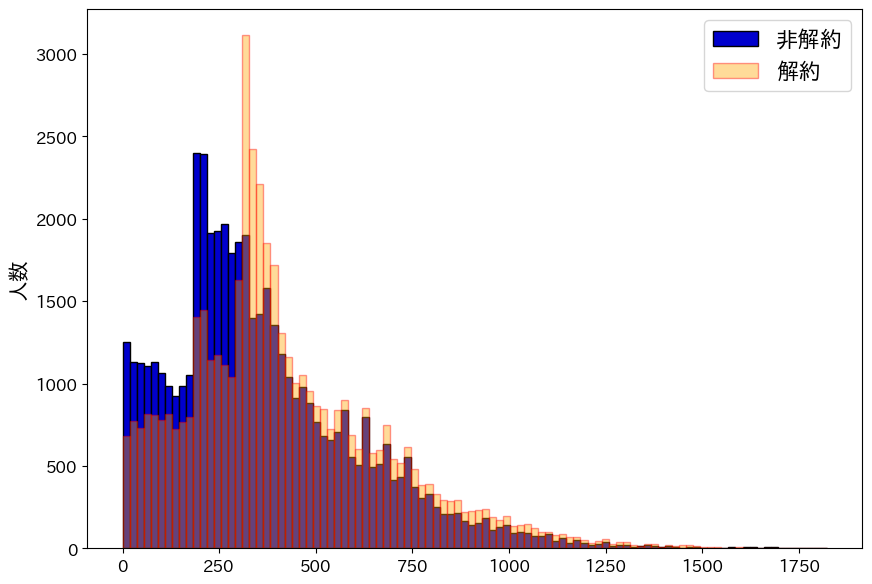

In [112]:
# グラフの大きさ指定

feau = ["eqpdays"]
plt.figure(figsize = (10, 7))

print("max", analy_df[feau].max())
print("min", analy_df[feau].min())

# x軸のラベルを指定
# plt.title()
plt.xlabel('', fontsize=15)
plt.ylabel("人数", fontsize=15)

# 対数スケールに設定
# plt.xscale('log')

# ヒストグラムの描写
# plt.hist(x=analy_df['avg6mou'], bins=100, range=(0, 3000), edgecolor='black')
plt.hist(x=analy_df[analy_df["churn"] == 0][feau], bins=100, range=(0, 1823), edgecolor='black', color="mediumblue", label='非解約')
plt.hist(x=analy_df[analy_df["churn"] == 1][feau], bins=100, range=(0, 1823), color="orange", edgecolor='red', alpha=0.4, label='解約')
# Seabornで描写する場合
#sns.histplot(data=df, x='sepal_length', bins=25, binrange=(4.5, 7.5))

# 目盛りのフォントサイズを変更
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.legend(fontsize='16')

plt.show()

In [111]:
analy_df[(0 <= analy_df["eqpdays"]) & (analy_df["eqpdays"] <= 300)]["churn"].mean()

0.3926520950846092

In [113]:

analy_df[(310 <= analy_df["eqpdays"])]["churn"].mean()

0.5618010851171473

In [214]:
0.6179461108286731 - 0.3835381982262331




0.23440791260244004

In [213]:
analy_df[(analy_df["eqpdays"] <= 60)]["churn"].mean()

0.3835381982262331

In [208]:
pd.options.display.float_format = '{:.2f}'.format

grpd_df = churned_data_train[(310 <= churned_data_train["eqpdays"])]


print("rate:", grpd_df["churn"].mean())
print("data amou:", grpd_df.shape[0])

ch0_df = grpd_df[grpd_df["churn"] == 0]
ch1_df = grpd_df[grpd_df["churn"] == 1]

print("ch 0 rev:", ch0_df["mou_Mean"].sum() * 0.1)
print("ch 1 rev:", ch1_df["mou_Mean"].sum() * 0.1)


rate: 0.6179461108286731
data amou: 39340
ch 0 rev: 614828.7958333436
ch 1 rev: 925031.8458333806


<Figure size 1000x700 with 0 Axes>

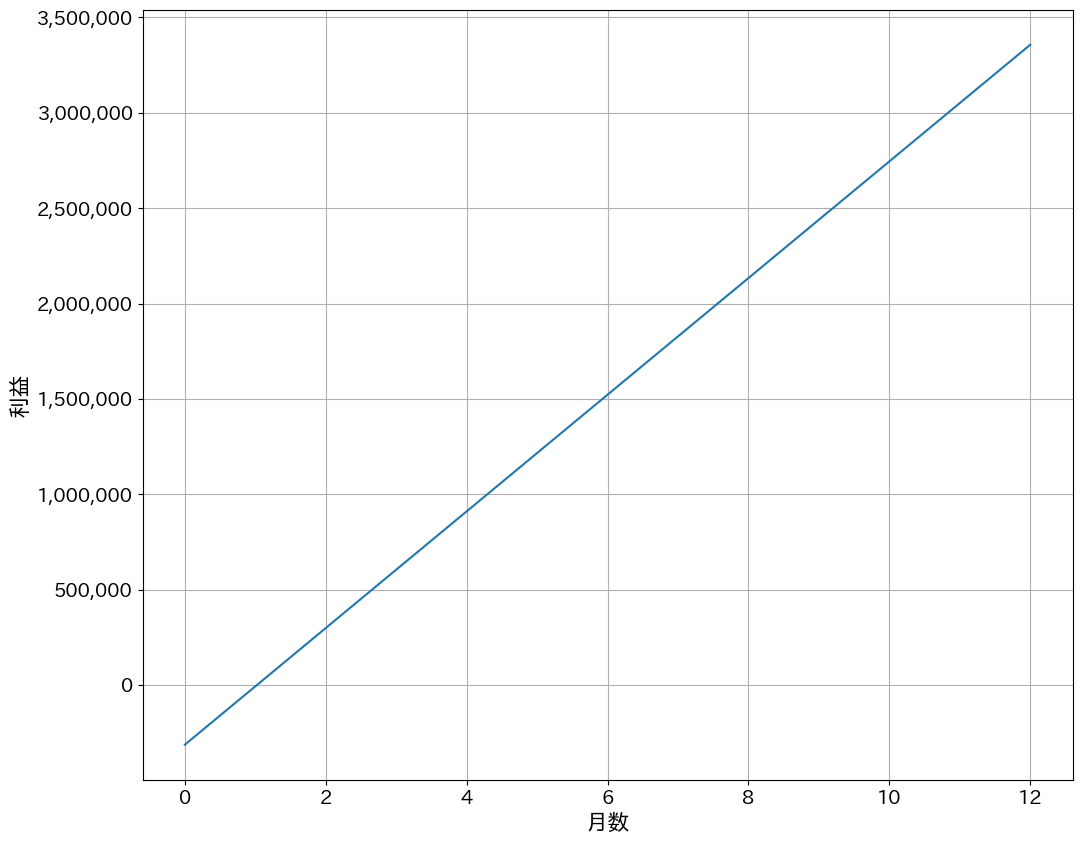

In [256]:
import matplotlib.ticker as ticker
# グラフ用のデータを格納するリスト
x_values = []
res_values = []

plt.figure(figsize = (10, 7))
# all_ch0_rev = (df3[df3["churn"] == 0]["rev_Mean"].sum())

# xが0.05増加するごとに計算
for month in np.arange(0, 13, 1):

    grpd_df3 = churned_data_train[310 <= churned_data_train["eqpdays"]]


    ch0_df = grpd_df3[grpd_df3["churn"] == 0]
    ch1_df = grpd_df3[grpd_df3["churn"] == 1]

    sampled_ch1_df = ch1_df.sample(frac=0.23440791260244004, random_state=42)  # random_stateは再現性のためのシード

    # df3 = pd.merge(analy_df, sampled_ch0_df, how='left', indicator=True).query('_merge == "left_only"').drop('_merge', axis=1)



    res = (sampled_ch1_df["rev_Mean"].sum()) * month - (grpd_df3["hnd_price"].sum())

    # グラフ用のデータを追加
    # x_values.append(sampled_ch0_df.shape[0] / ch1_df.shape[0])
    x_values.append(month)

    res_values.append(res)

# グラフの作成
    
pd.options.display.float_format = '{:.2f}'.format


plt.figure(figsize=(12, 10))
plt.plot(x_values, res_values, linestyle='-')
plt.xlabel('月数', fontsize=16)
plt.ylabel('利益', fontsize=16)
# plt.title('res vs. x')

plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.grid(True)
plt.show()

In [243]:
sampled_ch1_df.shape[0]

5698

In [242]:
grpd_df3 = churned_data_train[310 <= churned_data_train["eqpdays"]]


ch0_df = grpd_df3[grpd_df3["churn"] == 0]
ch1_df = grpd_df3[grpd_df3["churn"] == 1]

sampled_ch1_df = ch1_df.sample(frac=0.2344, random_state=42)  # random_stateは再現性のためのシード

# df3 = pd.merge(analy_df, sampled_ch0_df, how='left', indicator=True).query('_merge == "left_only"').drop('_merge', axis=1)



res = (sampled_ch1_df["rev_Mean"].sum()) * 12 - (grpd_df3["hnd_price"].sum())

res

3356772.7299999604

In [196]:
grpd_df3 = churned_data_train[310 <= churned_data_train["eqpdays"]]
grpd_df3["churn"].mean()

0.6179461108286731

In [199]:
grpd_df3["hnd_price"].sum()

312468

In [203]:
grpd_df3[grpd_df3["churn"] == 1]["rev_Mean"].sum() * 0.1691

219157.92036407662

In [205]:
analy_df[(analy_df["churn"] == 1) & ]["rev_Mean"].sum() * 0.1691

477035.81831273134

In [249]:
analy_df[(0 <= analy_df["eqpdays"]) & (analy_df["eqpdays"] < 10)]["hnd_price"].describe()

count   984.00
mean      8.12
std       5.98
min       0.00
25%       2.00
50%       5.00
75%      15.00
max      17.00
Name: hnd_price, dtype: float64

In [248]:
analy_df["hnd_price"].mean()

7.436262103591372

In [252]:
analy_df[(0 <= analy_df["eqpdays"])]["hnd_price"].describe()

count   97463.00
mean        7.43
std         5.35
min         0.00
25%         2.00
50%         8.00
75%        13.00
max        17.00
Name: hnd_price, dtype: float64